# Objective:
### Using the features of a loan dataset to classify the loan taken by the person as good or bad

 it's a classification Use case , so let's define cost first !
    
    True positives are Target column with value = good .
    True Negatives are Target column with value = bad .
    
    1 . a single False Positive result's in : 
            actual value    : risk is there (bad) .
            model predicts  : no risk (good) .
                
           *  so cost the is  lender may end up in giving loan to the applicant whose is not capable of paying it properly . 
    
    2 . a single False Negative result's in :
            actual value    : no risk (good) .
            model predicts  : risk is there (bad) .
                
            
           *  so cost the is lender may end up in not giving loan to the applicant whose is  capable of paying it properly ,
              which i inturn loses his business profit  .
            
 * so my point here is , we should build model with low FP and FN values , so i'll choosing f1-score as my performance metrics since 
   it's combo of recall and precision . 
        
        
            
                

# Overview : 

* Importing libraries
* reading data
* Data Preprocessing
* EDA 
    * Univariate Analysis 
    * Bivariate  Analysis 
* Feature Engineering 
* Feature Scaling 
* Model Building 
* Conclusion 
* Saving Model Locally 

# Importing libraries

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,classification_report
from sklearn import svm
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')


# reading data 

In [152]:
data = pd.read_csv("loan.tsv",delimiter = "\t")
test = pd.read_csv("test_loan.tsv",delimiter = "\t")
data.columns = [i.lower() for i in data.columns]
test.columns = [i.lower() for i in test.columns]
print("Train shape  : ",data.shape)
print("Test shape   : ",test.shape)

Train shape  :  (964, 10)
Test shape   :  (36, 9)


In [153]:
data.head()

,age,sex,job,housing,saving accounts,checking account,credit amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [154]:
test.head(2)

,age,sex,job,housing,saving accounts,checking account,credit amount,duration,purpose
0,31,male,2,own,little,moderate,1935,24,business
1,33,male,2,rent,little,little,950,15,car


# Data Preprocessing

In [155]:
data.isnull().mean()

age                 0.000000
sex                 0.000000
job                 0.000000
housing             0.000000
saving accounts     0.186722
checking account    0.396266
credit amount       0.000000
duration            0.000000
purpose             0.000000
risk                0.000000
dtype: float64

In [156]:
test.isnull().mean()

age                 0.000000
sex                 0.000000
job                 0.000000
housing             0.000000
saving accounts     0.083333
checking account    0.333333
credit amount       0.000000
duration            0.000000
purpose             0.000000
dtype: float64

In [157]:
# Let's drop sex column
data.drop(["sex"],axis = 1,inplace = True)
test.drop(["sex"],axis = 1,inplace = True)

In [158]:
# Let's impute saving accounts feature 
data[data["risk"]=="good"]["saving accounts"].value_counts()

little        373
moderate       69
quite rich     50
rich           41
Name: saving accounts, dtype: int64

In [159]:
data[data["risk"]=="bad"]["saving accounts"].value_counts()

little        205
moderate       30
quite rich     11
rich            5
Name: saving accounts, dtype: int64

In [160]:
# replacing nan value present in saving accounts feature with value = "little"
data["saving accounts"].fillna(value = data["saving accounts"].mode()[0],axis = 0,inplace = True)
test["saving accounts"].fillna(value = data["saving accounts"].mode()[0],axis = 0,inplace = True)

In [161]:
# Let's impute checking accounts feature 
data[data["risk"]=="good"]["checking account"].value_counts()

moderate    160
little      135
rich         49
Name: checking account, dtype: int64

In [162]:
data[data["risk"]=="bad"]["checking account"].value_counts()

little      130
moderate     94
rich         14
Name: checking account, dtype: int64

In [163]:
chec_acc_good = data[data["risk"]=="good"].loc[:]
chec_acc_bad = data[data["risk"]=="bad"].loc[:]

chec_acc_good["checking account"].fillna(chec_acc_good["checking account"].mode()[0],axis = 0 ,inplace = True)
chec_acc_bad["checking account"].fillna(chec_acc_bad["checking account"].mode()[0],axis = 0 ,inplace = True)

data = pd.concat([chec_acc_good,chec_acc_bad])

test["checking account"].fillna(data["checking account"].mode()[0],axis = 0 ,inplace = True)

In [164]:
# make sure no missing value . 
data.isnull().sum()

age                 0
job                 0
housing             0
saving accounts     0
checking account    0
credit amount       0
duration            0
purpose             0
risk                0
dtype: int64

In [165]:
test.isnull().sum()

age                 0
job                 0
housing             0
saving accounts     0
checking account    0
credit amount       0
duration            0
purpose             0
dtype: int64

# EDA

# Univariate analysis 

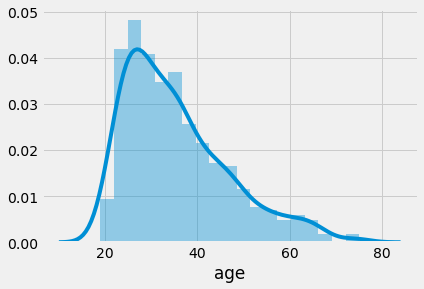

In [166]:
sns.distplot(data["age"])
plt.show()

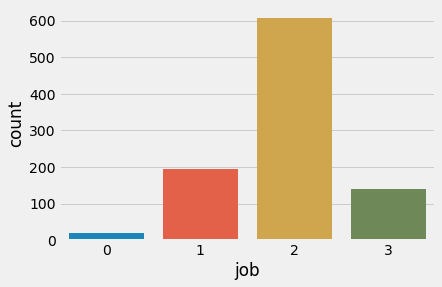

In [167]:
sns.countplot(data["job"])
plt.show()

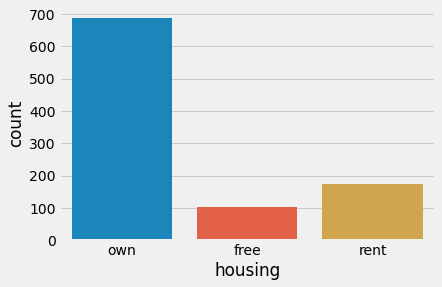

In [168]:
sns.countplot(data["housing"])
plt.show()

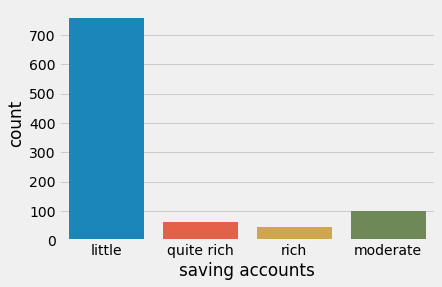

In [169]:
sns.countplot(data["saving accounts"])
plt.show()

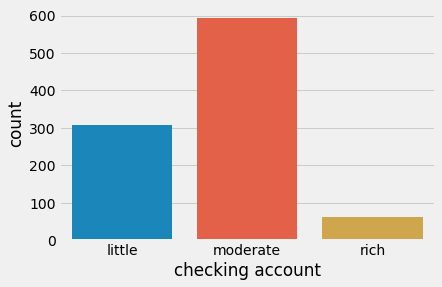

In [170]:
sns.countplot(data["checking account"])
plt.show()

In [171]:
print("Minimum credit amount : ",data["credit amount"].min())
print("Maximum credit amount : ",data["credit amount"].max())

Minimum credit amount :  250
Maximum credit amount :  18424


Text(0.5, 1.0, 'Credit Amount')

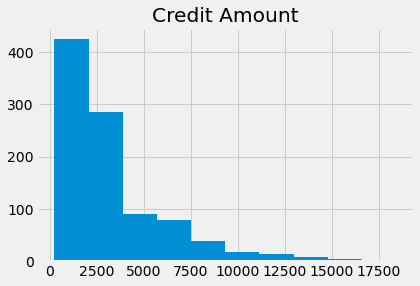

In [172]:
plt.hist(data["credit amount"])
plt.title("Credit Amount")

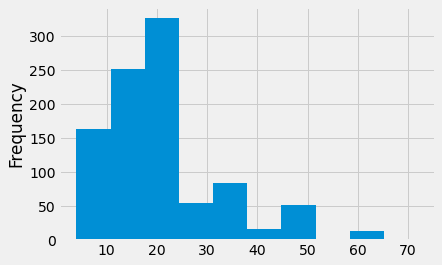

In [173]:
data["duration"].plot(kind = "hist")

In [174]:
print("Top 3 purpose : ")
data["purpose"].value_counts().head(3)

Top 3 purpose : 


car                    327
radio/TV               272
furniture/equipment    174
Name: purpose, dtype: int64

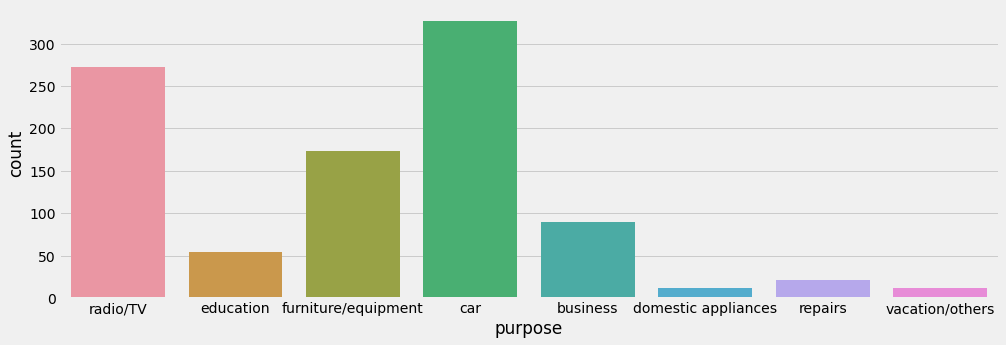

In [175]:
plt.rcParams['figure.figsize'] = (15,5)
sns.countplot(data["purpose"])
plt.show()

In [176]:
data['risk'].value_counts()

good    683
bad     281
Name: risk, dtype: int64

In [177]:
print("Percentage of good value in Target col : ",data['risk'].value_counts()[0]/len(data)*100)
print("Percentage of bad  value in Target col : ",data['risk'].value_counts()[1]/len(data)*100)

Percentage of good value in Target col :  70.850622406639
Percentage of bad  value in Target col :  29.149377593361


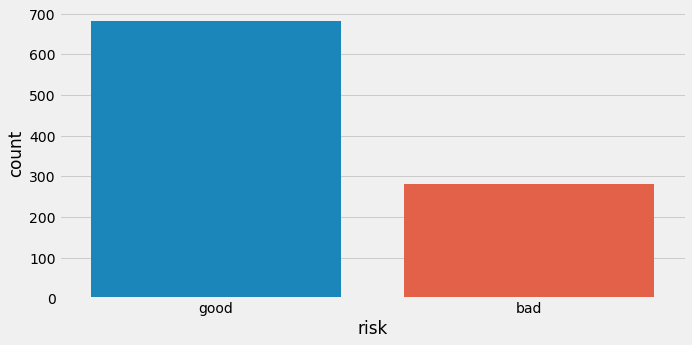

In [178]:
plt.rcParams['figure.figsize'] = (10,5)
sns.countplot(data["risk"])
plt.show()

# Bivariate analysis 

1 . age vs risk

  * from the below chart,we can conclude that people whose age is > 25 has a high chance of returning loan amount (less risk) .
  * median of two different are significantly differing ,for good = 35(median) ,bad = (30) by this we can conclude age is also playing vital role for risk analysis .
    

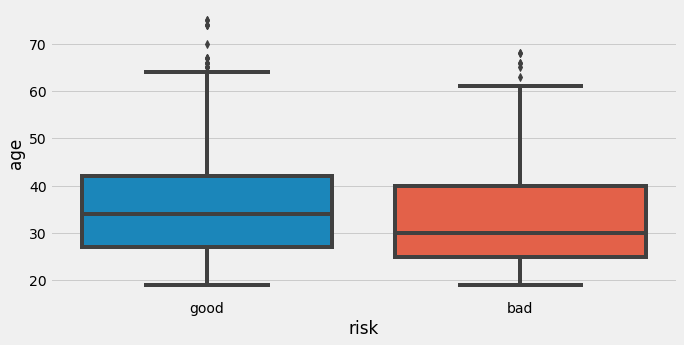

In [179]:
sns.boxplot(data["risk"],data["age"])
plt.show()

2 . job vs risk (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident,2 - skilled, 3-highly skilled )

   * from the below we conclude that skilled people are having high chance of returning loan (less risk) as well as high chance of not returning loan (high risk).

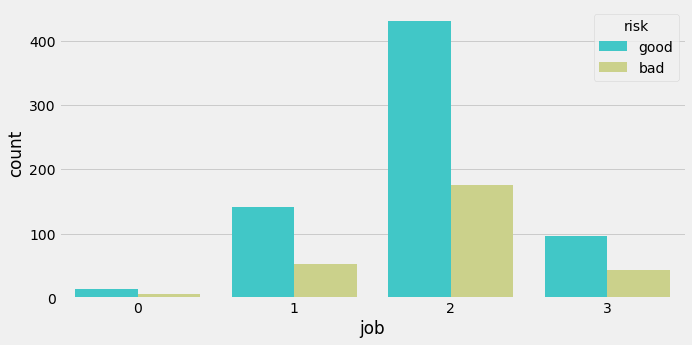

In [180]:
sns.countplot(data["job"],hue = data["risk"],palette = "rainbow")
plt.show()

3 . housing vs risk 
  * people who are having own house has high probablity of returning loan amount( less risk) .

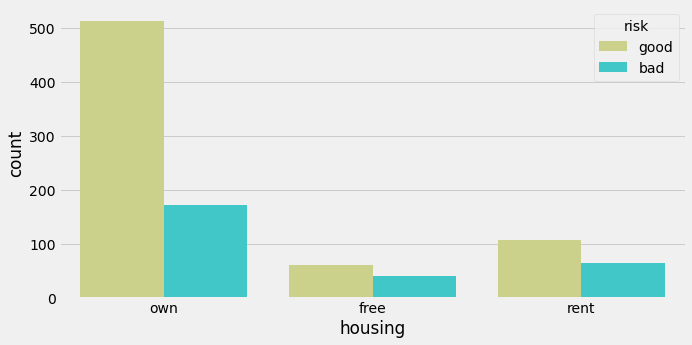

In [181]:
sns.countplot(data["housing"],hue = data["risk"],palette = "rainbow_r")
plt.show()

4 . purpose vs risk
* there is high chance of returning loan amount ,if it is car loan,equipment loan,Tv loans  because if the loan applicant did'nt pays loan amount properly , then lender will takes applicant car instead of money .

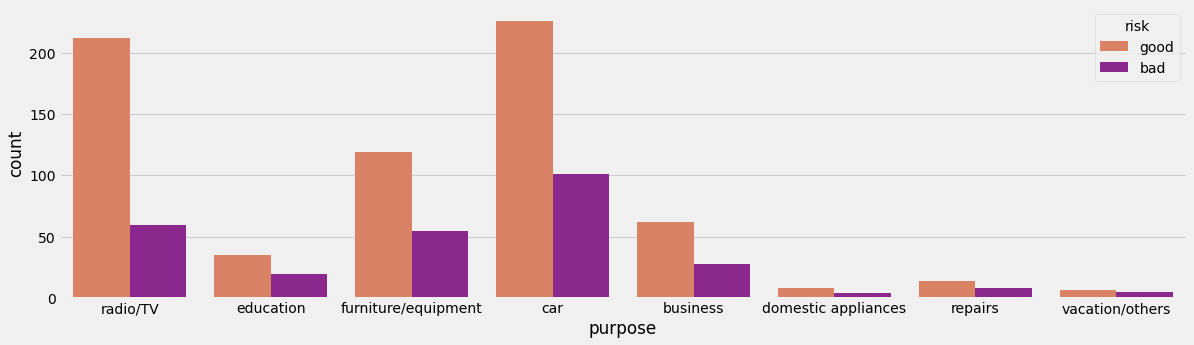

In [182]:
plt.rcParams['figure.figsize'] = (18,5)
sns.countplot(data["purpose"],hue = data["risk"],palette = "plasma_r")
plt.show()

5 . credit amount vs duration .
* we can see slight linear relationship between these features. 

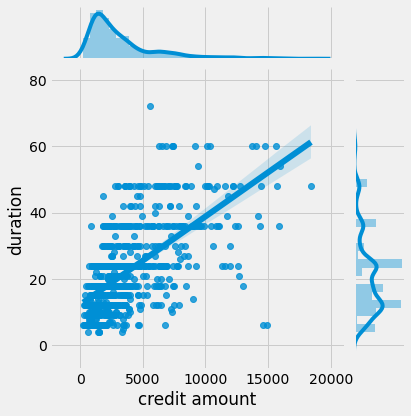

In [183]:
sns.jointplot(data["credit amount"],data["duration"],kind = "reg")

In [184]:
data.head(2)

,age,job,housing,saving accounts,checking account,credit amount,duration,purpose,risk
0,67,2,own,little,little,1169,6,radio/TV,good
2,49,1,own,little,moderate,2096,12,education,good


# Feature Engineering

In [185]:
data["risk"]    = data["risk"].map({"good":1,"bad":0})
data["housing"] = data["housing"].map({"own":3,"rent":2,"free":1})
data["saving accounts"] = data["saving accounts"].map({"little":1,"moderate":2,"quite rich":3,"rich":4})
data["checking account"] = data["checking account"].map({"little":1,"moderate":2,"rich":3})
data["purpose"] = data["purpose"].map({"domestic appliances":1,"repairs":2,"education":2,"radio/TV":2,"business":3,"car":3,"furniture/equipment":3,"vacation/others":4 })

In [186]:
test["housing"] = test["housing"].map({"own":3,"rent":2,"free":1})
test["saving accounts"] = test["saving accounts"].map({"little":1,"moderate":2,"quite rich":3,"rich":4})
test["checking account"] = test["checking account"].map({"little":1,"moderate":2,"rich":3})
test["purpose"] = test["purpose"].map({"domestic appliances":1,"repairs":2,"education":2,"radio/TV":2,"business":3,"car":3,"furniture/equipment":3,"vacation/others":4 })

# Feature Scaling 

In [187]:
# coverting skewed data into normalized data . 
data["credit amount"] = np.log(data["credit amount"])
data["age"] = np.log(data["age"])
data["duration"] = np.log(data["duration"])

# for test data
test["credit amount"] = np.log(data["credit amount"])
test["age"] = np.log(data["age"])
test["duration"] = np.log(data["duration"])

In [188]:
data.head(2)

,age,job,housing,saving accounts,checking account,credit amount,duration,purpose,risk
0,4.204693,2,3,1,1,7.063904,1.791759,2,1
2,3.891820,1,3,1,2,7.647786,2.484907,2,1


In [189]:
test.head(2)

,age,job,housing,saving accounts,checking account,credit amount,duration,purpose
0,1.436201,2,3,1,2,1.954998,0.583198,3
1,1.128508,2,2,1,1,2.162324,1.353565,3


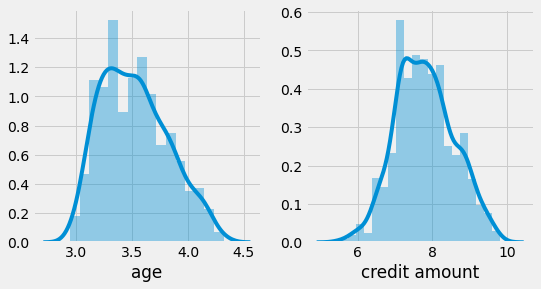

In [190]:
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
sns.distplot(data["age"])

plt.subplot(122)
sns.distplot(data["credit amount"])

plt.show()

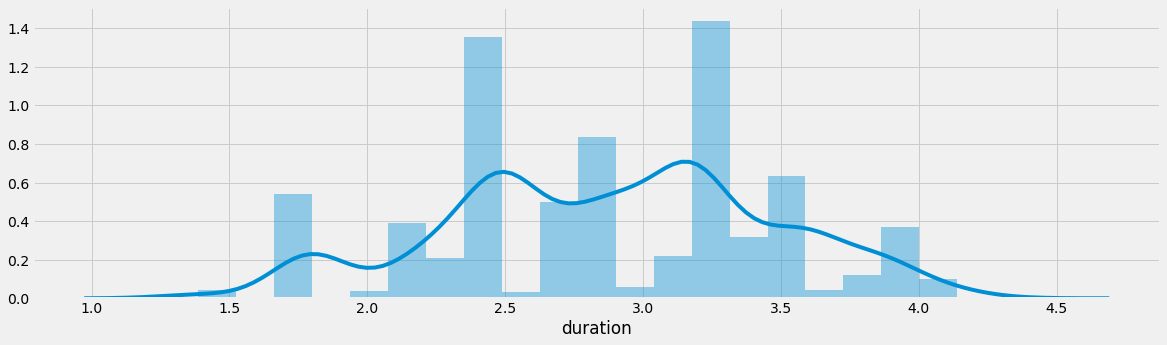

In [191]:
sns.distplot(data["duration"])

In [192]:
data.head()

,age,job,housing,saving accounts,checking account,credit amount,duration,purpose,risk
0,4.204693,2,3,1,1,7.063904,1.791759,2,1
2,3.891820,1,3,1,2,7.647786,2.484907,2,1
3,3.806662,2,1,1,1,8.972337,3.737670,3,1
5,3.555348,1,1,1,2,9.111072,3.583519,2,1
6,3.970292,2,3,3,2,7.949797,3.178054,3,1


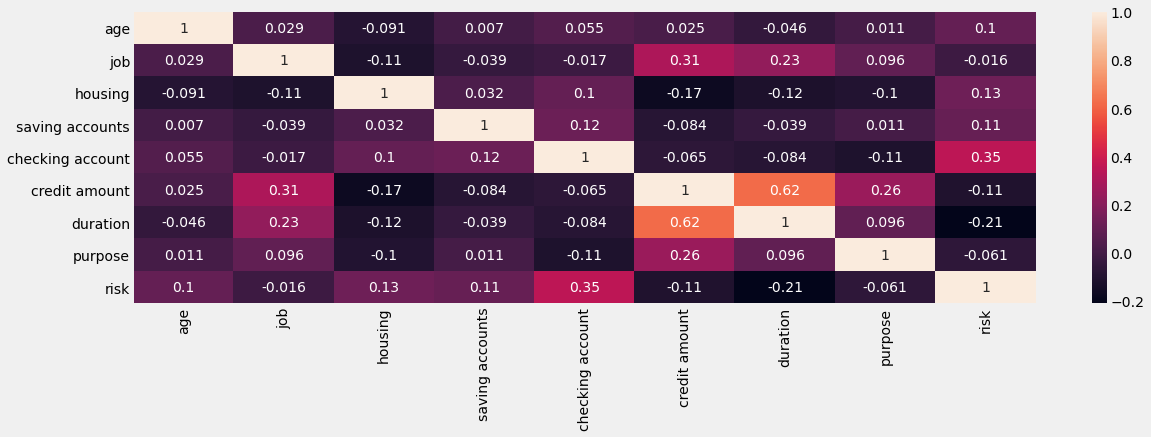

In [193]:
sns.heatmap(data.corr(),annot= True)

# Comparing different Models and using the best one 

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [195]:
result = pd.DataFrame({"Algorithms":["LogReg","LogReg","LogReg","Dtree","Dtree","Dtree","svm","svm","svm","xgb","xgb","xgb"],
                       "Techniques":["oversample","undersample","smote","oversample","undersample","smote","oversample","undersample","smote","oversample","undersample","smote"],"Accuracy" : [0,0,0,0,0,0,0,0,0,0,0,0],"recall" : [0,0,0,0,0,0,0,0,0,0,0,0],"Precision":[0,0,0,0,0,0,0,0,0,0,0,0],"F1-score" :[0,0,0,0,0,0,0,0,0,0,0,0]})
result

,Algorithms,Techniques,Accuracy,recall,Precision,F1-score
0,LogReg,oversample,0,0,0,0
1,LogReg,undersample,0,0,0,0
2,LogReg,smote,0,0,0,0
3,Dtree,oversample,0,0,0,0
4,Dtree,undersample,0,0,0,0
5,Dtree,smote,0,0,0,0
6,svm,oversample,0,0,0,0
7,svm,undersample,0,0,0,0
8,svm,smote,0,0,0,0
9,xgb,oversample,0,0,0,0


In [196]:
#  Counter Var's 
lrcnt = 0
dtcnt = 3
svcnt = 6
xgcnt = 9
cnt   = 0 

In [197]:
for i in range(3):
    x = data.drop(["risk"],axis = 1).copy()
    y = data["risk"]
    # xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0,3,random_state = 33)
    
    if(i==0 or i==1):
        
        good = data[data["risk"]==1]
        bad  = data[data["risk"]==0]
        
        if(i==0):
            # Let's do oversampling of minority class i.e 1 in our case
            oversampled = bad.sample(n = len(good),replace = True)
            d1 =  oversampled
            d2 =  good
        
        elif(i==1):
            # Let's do undersampling of majaority class i.e 1 in our case
            undersampled = good.sample(n = len(bad),replace = True)
            d1 = undersampled
            d2 = bad
        
        dnew = pd.concat([d1,d2])
        x = dnew.drop(["risk"],axis = 1).copy()
        y = dnew["risk"]
        
    else:
        
        # Applying SMOTE Algorithm (Synthetic Minority Oversampling Technique's . )
        sm = SMOTE(sampling_strategy = 1.0,random_state = 33,n_jobs = -1)
        x,y = sm.fit_sample(x,y)
    
    for j in range(4):
        if(j==0):
            clf = LogisticRegression()
            cnt = lrcnt
            lrcnt+=1
        elif(j==1):
            clf = DecisionTreeClassifier(random_state = 33,min_samples_split = 5,min_samples_leaf =10)
            cnt = dtcnt
            dtcnt+=1
        elif(j==2):
            clf = svm.SVC()
            cnt = svcnt
            svcnt+=1
        else:
            clf = XGBClassifier()
            cnt = xgcnt
            xgcnt+=1
            
        
        clf.fit(x,y)
        ypred = clf.predict(x)
        
        result.iloc[cnt,2] = round(100*accuracy_score(y,ypred),2)
        result.iloc[cnt,3] = round(100*precision_score(y,ypred),2)
        result.iloc[cnt,4] = round(100*recall_score(y,ypred),2)
        result.iloc[cnt,5] = round(100*f1_score(y,ypred),2)
            
            
        
            
        
       

In [198]:
result

,Algorithms,Techniques,Accuracy,recall,Precision,F1-score
0,LogReg,oversample,76.28,75.98,76.87,76.42
1,LogReg,undersample,74.02,73.68,74.73,74.20
2,LogReg,smote,74.23,73.61,75.55,74.57
3,Dtree,oversample,86.46,88.54,83.75,86.08
4,Dtree,undersample,81.32,85.48,75.44,80.15
5,Dtree,smote,82.50,85.69,78.04,81.69
6,svm,oversample,72.84,69.90,80.23,74.71
7,svm,undersample,71.00,68.44,77.94,72.88
8,svm,smote,71.52,68.33,80.23,73.80
9,xgb,oversample,99.93,100.00,99.85,99.93


In [199]:
x = data.drop(["risk"],axis = 1).copy()
y = data["risk"]

good = data[data["risk"]==1]
bad  = data[data["risk"]==0]

oversampled = bad.sample(n = len(good),replace = True)
d1 =  oversampled
d2 =  good

dnew = pd.concat([d1,d2])
x = dnew.drop(["risk"],axis = 1).copy()
y = dnew["risk"]

In [200]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Model Building

## DecisionTree

In [201]:
dt = DecisionTreeClassifier(random_state = 33)

# Setting Parameters for DecisionTreeClassifier . 

params = {  
             'criterion'    : ["gini", "entropy"],
             'max_features' : ["auto", "sqrt", "log2"],
              'min_samples_split' :[i for i in range(4,16)],
              'min_samples_leaf' : [i for i in range(4,16)]
         }

dt_clf = RandomizedSearchCV(dt,param_distributions = params,cv = 10)
dt_clf.fit(x,y)
dt_clf.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'criterion': 'entropy'}

In [202]:
# FOR Training data . 
y_train_pred = dt_clf.predict(x)
print(classification_report(y_train_pred,y))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       733
           1       0.83      0.90      0.87       633

    accuracy                           0.87      1366
   macro avg       0.87      0.87      0.87      1366
weighted avg       0.87      0.87      0.87      1366



In [203]:
print(confusion_matrix(y_train_pred,y))

[[620 113]
 [ 63 570]]


### for testing data

In [204]:
ytest = dt_clf.predict(test)
ytest.ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [205]:
# Decision tree working awesome , i feel even random forest works good .

## XGBoost

In [206]:
xgb = XGBClassifier(random_state = 33)
# Setting Parameters for xgb . 

params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'n_estimators' : [50,100,150,200]
        
    }
xgb = RandomizedSearchCV(xgb,param_distributions = params,cv = 10,random_state = 33)
xgb.fit(x,y)
xgb.best_params_

{'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 7,
 'learning_rate': 0.1}

In [207]:
# FOR Training data . 
y_train_pred = xgb.predict(x)
print(classification_report(y_train_pred,y))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       692
           1       0.98      0.99      0.99       674

    accuracy                           0.99      1366
   macro avg       0.99      0.99      0.99      1366
weighted avg       0.99      0.99      0.99      1366



In [208]:
print(confusion_matrix(y_train_pred,y))

[[678  14]
 [  5 669]]


In [209]:
# for test data . 
ytest = xgb.predict(test)
ytest.ravel()

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

In [210]:
# Note : i'm feeling the result of xgboost model is  overfitted ! 
# again we can't sure anything 100% due to less availablity of data . 

# Conclusion ( points  to be considered for less risk  )
* age should be between 28-40 
* people should be skilled w.r.t thier job .
* house should be of own .
* sav_acc and check_acc history should be good wrt transaction .
* credit amount should be high and duration should be 1 - 2.5 years ( it depends on purpose )
* pupose should be car or equipment or tv realted loans .

# saving model locally,

In [211]:
# i am going to choose XGBOOST as my final model because of it's performance 

In [212]:
import pickle

In [213]:
filename = 'finalized_model.pickle'
pickle.dump(xgb, open(filename, 'wb'))